Found 935 images belonging to 3 classes.
Found 232 images belonging to 3 classes.
Epoch 1/25
30/30 [==============================] - ETA: 0s - loss: 0.5554 - accuracy: 0.7807
Epoch 1: val_loss improved from inf to 1.27284, saving model to logs/best_model.h5
30/30 [==============================] - 95s 1s/step - loss: 0.5554 - accuracy: 0.7807 - val_loss: 1.2728 - val_accuracy: 0.7241 - lr: 0.0010
Epoch 2/25
30/30 [==============================] - ETA: 0s - loss: 0.2210 - accuracy: 0.9176
Epoch 2: val_loss improved from 1.27284 to 0.93781, saving model to logs/best_model.h5
30/30 [==============================] - 41s 1s/step - loss: 0.2210 - accuracy: 0.9176 - val_loss: 0.9378 - val_accuracy: 0.9052 - lr: 0.0010
Epoch 3/25
30/30 [==============================] - ETA: 0s - loss: 0.2169 - accuracy: 0.9326
Epoch 3: val_loss did not improve from 0.93781
30/30 [==============================] - 38s 1s/step - loss: 0.2169 - accuracy: 0.9326 - val_loss: 44.4245 - val_accuracy: 0.3750 - lr:

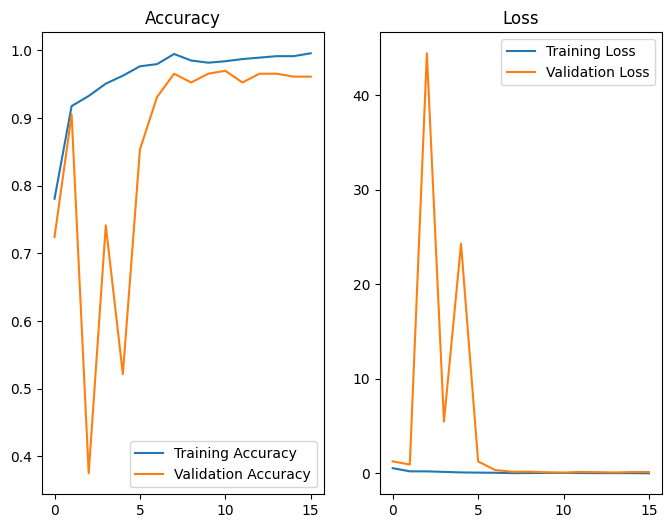

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


def data_loading(data_dir, target_size=(256, 256), batch_size=32, validation_split=0.2):
    datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=0.15,
        vertical_flip=0.15,
        validation_split=validation_split
    )

    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        color_mode="rgb",
        batch_size=batch_size,
        class_mode="categorical",
        subset='training'
    )

    val_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        color_mode="rgb",
        batch_size=batch_size,
        class_mode="categorical",
        subset='validation'
    )

    return train_generator, val_generator


def model(input_shape, num_classes):
    base_model = Xception(
        include_top=False,
        input_shape=input_shape,
        pooling="avg"
    )
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(
        loss="categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy"]
    )

    return model


def training(model, train_generator, val_generator, log_folder):
    checkpoint = ModelCheckpoint(
        os.path.join(log_folder, 'best_model.h5'),
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
        verbose=1
    )
    tensorboard_callback = TensorBoard(
        log_dir=log_folder,
        histogram_freq=1
    )

    history = model.fit(
        train_generator,
        epochs=25,
        validation_data=val_generator,
        callbacks=[checkpoint, early_stopping, reduce_lr, tensorboard_callback]
    )

    return history


def evaluation(model, val_generator):
    test_loss, test_acc = model.evaluate(val_generator)
    print("Test accuracy: {:.2%}".format(test_acc))

    test_preds = model.predict(val_generator)
    test_labels = np.argmax(test_preds, axis=-1)

    conf_mat = confusion_matrix(test_labels, val_generator.classes)
    print(conf_mat)
    # Plot the training and validation accuracy and loss
    acc_plt=(plt.figure(figsize=(8, 6)),
    plt.subplot(1, 2, 1),
    plt.plot(history.history['accuracy'], label='Training Accuracy'),
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy'),
    plt.legend(),
    plt.title('Accuracy'))

    los_plt=(plt.subplot(1, 2, 2),
    plt.plot(history.history['loss'], label='Training Loss'),
    plt.plot(history.history['val_loss'], label='Validation Loss'),
    plt.legend(),
    plt.title('Loss'),
    plt.show())

# Load the dataset
data_dir = "/content/drive/MyDrive/train"

# Define the number of classes
num_classes = 3

# Load and split the data
train_generator, val_generator = data_loading(data_dir)

# Build the model
input_shape = (256, 256, 3)
model = model(input_shape, num_classes)

# Define the log folder for callbacks
log_folder = 'logs'

# Train the model
history = training(model, train_generator, val_generator, log_folder)

# Evaluate the model
evaluation(model, val_generatoracc)

# Save the trained model
model.save("/path/to/save/trained_model.hdf5")